In [1]:
## Install and import packages
# Darts: https://unit8co.github.io/darts/README.html
!pip install darts
!pip install dask[dataframe]

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.metrics.metrics import rmse
from darts.models import RandomForest, XGBModel
from darts.timeseries import TimeSeries

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0

In [3]:
## Load data
drive.mount('/content/drive')
path = '/content/drive/My Drive/deep learning project summer 2024/data'
df = pd.read_csv(os.path.join(path, 'BD_combined_final.csv'))

## Parameters
frac_train = 0.999
series = TimeSeries.from_dataframe(df, time_col='date')
train, val = series.split_before(frac_train)
horizon = 12

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)
target = train_scaled['case']

Mounted at /content/drive


Average Random Forest RMSE: 10514.931761437585
Average XGBoost RMSE: 11044.65222012024


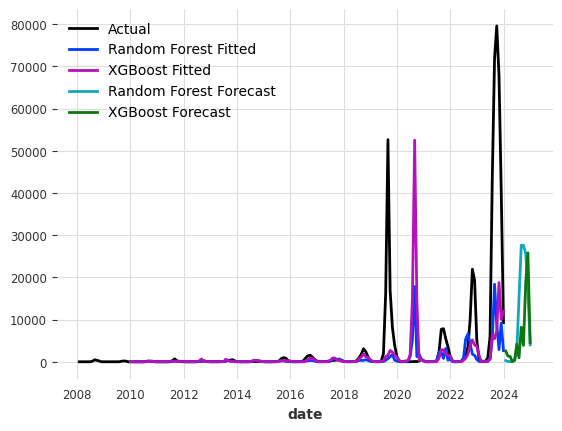

In [4]:
n_iter = 4
rmse_RFs = []
rmse_XGBs = []
for i in range(n_iter):
  # Random Forest
  model_RF = RandomForest(lags=12, output_chunk_length=horizon, n_estimators=10, criterion='squared_error')
  model_RF.fit(series_scaled)
  train_pred_RF = scaler.inverse_transform(model_RF.historical_forecasts(series_scaled, show_warnings=False))
  pred_RF = scaler.inverse_transform(model_RF.predict(horizon))
  rmse_RF = rmse(train_pred_RF['case'], train['case'][-len(train_pred_RF['case']):])
  rmse_RFs.append(rmse_RF)

  # XGBoost
  model_XGB = XGBModel(lags=10, output_chunk_length=horizon)
  model_XGB.fit(series_scaled)
  train_pred_XGB = scaler.inverse_transform(model_XGB.historical_forecasts(series_scaled, show_warnings=False))
  pred_XGB = scaler.inverse_transform(model_XGB.predict(horizon))
  rmse_XGB = rmse(train_pred_XGB['case'], train['case'][-len(train_pred_XGB['case']):])
  rmse_XGBs.append(rmse_XGB)

print(f'Average Random Forest RMSE: {np.mean(rmse_RFs)}')
print(f'Average XGBoost RMSE: {np.mean(rmse_XGBs)}')

plt.figure()
series['case'].plot(label='Actual')
train_pred_RF['case'].plot(label='Random Forest Fitted')
train_pred_XGB['case'].plot(label='XGBoost Fitted')
pred_RF['case'].plot(label='Random Forest Forecast')
pred_XGB['case'].plot(label='XGBoost Forecast')
plt.show()

In [5]:
print(TimeSeries.pd_dataframe(pred_RF['case']))
print(TimeSeries.pd_dataframe(pred_XGB['case']))

component      case
date               
2024-01-31    267.7
2024-02-29     74.9
2024-03-31     50.7
2024-04-30     68.1
2024-05-31    379.1
2024-06-30   2155.3
2024-07-31  15131.2
2024-08-31  27615.6
2024-09-30  27604.3
2024-10-31  25631.8
2024-11-30  16687.4
2024-12-31   3997.8
component           case
date                    
2024-01-31   2543.078125
2024-02-29   1361.050781
2024-03-31   1275.957275
2024-04-30     34.239677
2024-05-31    325.172546
2024-06-30   4162.885254
2024-07-31    934.601501
2024-08-31   8196.081055
2024-09-30   3863.289795
2024-10-31  18806.050781
2024-11-30  25828.240234
2024-12-31   4547.792480
